<a href="https://colab.research.google.com/github/AlexanderCardarasUCSC/EEG-Decoding-to-Images/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Directions:
- **Execute** mount drive cell
- **Skip** load, convert and save data to Numpy files section
- **Execute** cells starting from **Classify the EEG wave data section**

**Complete the following steps before running the cells below**

1.
Change runtime to GPU 

>Runtime > Change runtime type > GPU

2.
For each of the following link, add a Google Drive shortcut to your Drive root folder(My Drive):

>https://drive.google.com/drive/folders/1z8wcew5R7GCeu5s7SSsWw8bUcx1urVmk?usp=sharing

**Mount drive**

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Load, convert and save data to Numpy files
- only executed once to generate .npy files
- load the .npy files directly for future use

In [ ]:
import torch
import numpy as np
from numpy import save
from numpy import load

In [ ]:
# use the default data_path
# eeg_55_95_std.pth - saved
# eeg_14_70_std.pth - saved
# eeg_5_95_std.pth - saved

raw_data_path = "/content/gdrive/MyDrive/EEG2Image/eeg_55_95_std.pth"
save_data_path = "/content/gdrive/MyDrive/EEG2Image/data/"

In [ ]:
# load eeg data from .pth files
loaded = torch.load(raw_data_path)
data = loaded['dataset']        
labels = loaded["labels"]
images = loaded["images"]
size = len(data)
print(size)

11965


In [ ]:
# convert data tensors to np
eeg_data = []
labels = []

# crop the first 20ms and last 40ms out
time_low = 20
time_high = 460

verbose = False # set to True to print information on the data

for i in range(size):
    if verbose:
        data_i = data[i]
        print("Keys stored in each data[i] object:", data_i.keys())

        eeg_i = data[i]["eeg"]
        print("Shape of data[i][\"eeg\"]:", eeg_i.shape)
        print("Type of data[i][\"eeg\"]:", eeg_i.type)
        print()

        eeg_f = data[i]["eeg"].float() # simply converts to float
        print("Shape of data[i][\"eeg\"].float():", eeg_f.shape)
        print("Type of data[i][\"eeg\"].float():", eeg_f.type)
        print()

        eeg_t = data[i]["eeg"].float().t() # transposes the matrix
        print("Shape of data[i][\"eeg\"].float().t():", eeg_t.shape)
        print("Type of data[i][\"eeg\"].float().t():", eeg_t.type)
        print()

        image = data[i]["image"]
        print("image:", image)

        label = data[i]["label"]
        print("label:", label)

        subject = data[i]["subject"]
        print("subject:", subject)

    eeg = data[i]["eeg"].float().t()
    eeg = eeg[time_low:time_high,:] # trim the data to between 0.2s - 0.46s
    label = data[i]["label"]

    # convert from tensor to numpy
    eeg_data.append(eeg.numpy())
    labels.append(label)

eeg_data = np.asarray(eeg_data)
labels = np.asarray(labels)
print("Shape of EEG data:", eeg_data.shape)
print("Shape of labels:", labels.shape)

Shape of EEG data: (11965, 440, 128)
Shape of labels: (11965,)


### Information about the .pth file data
- 6 subjects
- 40 image classes
- 50 images per class

6 subjects * 40 classes * 50 images/class = 12,000 segments
- each image (segment) = .5 ms @ 1kHz = 500 samples during the segment
- each sample = 128 channels

each segment = 128 * 500 voltage values

In [ ]:
save("/content/gdrive/MyDrive/EEG2Image/data/eeg_55_95.npy", eeg_data)
save("/content/gdrive/MyDrive/EEG2Image/data/labels_55_95.npy", labels)

In [ ]:
eeg_data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_55_95.npy")
labels = load("/content/gdrive/MyDrive/EEG2Image/data/labels_55_95.npy")

In [ ]:
print(eeg_data.shape)

(11965, 440, 128)


# Classify the EEG wave data
- load the data
- build a model
- train the model
- evaluate
- predict

**Load the Data**

In [ ]:
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
# options for data separated by frequency bands
# eeg_55_95.npy
# eeg_14_70.npy
# eeg_5_95.npy

data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_5_95.npy")
labels = load("/content/gdrive/MyDrive/EEG2Image/data/labels_5_95.npy")

In [ ]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (11965, 440, 128)
Labels shape: (11965,)


**LSTM stuff**

In [ ]:
# initialize training and test data
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.20, random_state = 42)
print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)

# one hot encode the labels
y_train = to_categorical(y_train, 40)
y_test = to_categorical(y_test, 40)

Shape of x_train: (9572, 440, 128)
Shape of y_train: (9572,)
Shape of x_test: (2393, 440, 128)
Shape of y_test: (2393,)


In [ ]:
# define parameters
BATCH_SIZE = 16
EPOCHS = 50

TIMESTEPS = len(data[0])
TOTAL_INPUTS = len(data)
DATA_POINTS = TOTAL_INPUTS * TIMESTEPS 
FEATURES = len(x_train[0][0])

print('TIMESTEPS =', TIMESTEPS)
print('TOTAL_INPUTS =', TOTAL_INPUTS)
print('DATA_POINTS =', DATA_POINTS)
print('FEATURES =', FEATURES)

TIMESTEPS = 440
TOTAL_INPUTS = 11965
DATA_POINTS = 5264600
FEATURES = 128


In [ ]:
# LSTM model
model = Sequential()
#model.add(LSTM(128, batch_input_shape = (BATCH_SIZE, TIMESTEPS, FEATURES))) 
model.add(LSTM(16, input_shape = (TIMESTEPS, FEATURES)))
model.add(Dense(40, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dense_5 (Dense)              (None, 40)                680       
Total params: 9,960
Trainable params: 9,960
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
history = model.fit(
    x_train, 
    y_train,
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    verbose=2)

Epoch 1/50
599/599 - 9s - loss: 3.6998 - accuracy: 0.0259
Epoch 2/50
599/599 - 7s - loss: 3.6402 - accuracy: 0.0472
Epoch 3/50
599/599 - 7s - loss: 3.5244 - accuracy: 0.0625
Epoch 4/50
599/599 - 7s - loss: 3.4035 - accuracy: 0.0750
Epoch 5/50
599/599 - 7s - loss: 3.3578 - accuracy: 0.0771
Epoch 6/50
599/599 - 7s - loss: 3.2310 - accuracy: 0.0930
Epoch 7/50
599/599 - 7s - loss: 3.1756 - accuracy: 0.1008
Epoch 8/50
599/599 - 7s - loss: 3.1064 - accuracy: 0.1069
Epoch 9/50
599/599 - 7s - loss: 3.0531 - accuracy: 0.1098
Epoch 10/50
599/599 - 7s - loss: 3.0404 - accuracy: 0.1159
Epoch 11/50
599/599 - 7s - loss: 2.9898 - accuracy: 0.1204
Epoch 12/50
599/599 - 7s - loss: 2.9238 - accuracy: 0.1265
Epoch 13/50
599/599 - 7s - loss: 2.8564 - accuracy: 0.1268
Epoch 14/50
599/599 - 7s - loss: 2.8708 - accuracy: 0.1290
Epoch 15/50
599/599 - 7s - loss: 2.8560 - accuracy: 0.1325
Epoch 16/50
599/599 - 7s - loss: 2.8225 - accuracy: 0.1366
Epoch 17/50
599/599 - 7s - loss: 2.7218 - accuracy: 0.1499
Epoch 

In [ ]:
train_loss,train_acc = model.evaluate(x_train,y_train)
test_loss, test_acc = model.evaluate(x_test,y_test)
print('Training set accuracy:', train_acc)
print('Test set accuracy:', test_acc)

75/75 [==============================] - 1s 10ms/step - loss: 2.6777 - accuracy: 0.1617
Training set accuracy: 0.2054951936006546
Test set accuracy: 0.16172169148921967


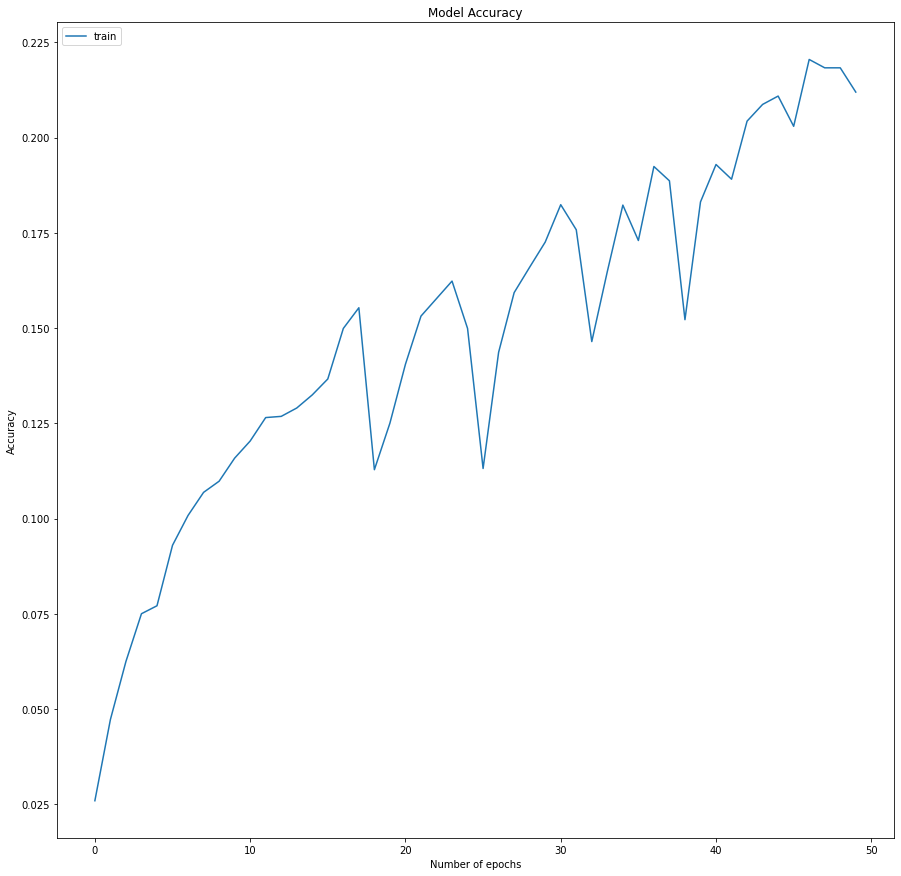

In [ ]:
plt.figure(figsize = (15,15))
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
num_predictions = 100
correct_pred = 0
pred = np.argmax(model.predict(x_test[0:num_predictions]), axis=-1)
print_count = 0

print("Predicted class : Class label")
for i in range(num_predictions):
    label = np.argmax(y_test[i])
    #print(pred[i], "=?", label)
    print("{:2s} : {:2s}".format(str(pred[i]), str(label)), end= "     ")
    
    print_count += 1
    if print_count == 5:
        print()
        print_count = 0

    if pred[i] == label:
        correct_pred += 1

print("\nTotal correct predictions:", correct_pred)
print("Percent correct:", correct_pred/num_predictions)

Predicted class : Class label
39 : 39     38 : 17     15 : 24     4  : 14     9  : 23     
0  : 37     17 : 10     17 : 4      19 : 7      26 : 6      
20 : 23     26 : 23     22 : 26     13 : 29     10 : 15     
31 : 25     13 : 25     20 : 14     34 : 4      3  : 3      
11 : 0      33 : 2      14 : 16     7  : 32     39 : 11     
8  : 35     19 : 1      16 : 26     16 : 30     31 : 26     
17 : 25     1  : 29     13 : 32     27 : 20     12 : 8      
10 : 34     17 : 17     31 : 16     3  : 36     33 : 9      
36 : 18     11 : 0      37 : 25     6  : 6      35 : 11     
37 : 4      12 : 39     35 : 3      36 : 3      8  : 28     
13 : 7      19 : 19     39 : 21     19 : 29     12 : 5      
3  : 3      20 : 1      2  : 23     35 : 28     14 : 14     
16 : 30     12 : 0      27 : 4      15 : 10     27 : 1      
24 : 4      33 : 29     27 : 6      0  : 11     10 : 17     
34 : 4      4  : 4      14 : 14     37 : 17     37 : 25     
37 : 34     39 : 14     25 : 16     27 : 26     25 : 5 

# Conditional VAE

**Load data**

In [2]:
!cp /content/gdrive/MyDrive/EEG2Image/data/image_mapping.npy /content

**Import libraries**

In [3]:
# prerequisites
import collections
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda, concatenate
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.utils import to_categorical
from scipy.stats import norm

In [4]:
def array_to_image(img):
    return img.reshape(3, 64, 64).transpose(1, 2, 0) / np.float32(255)


def save_images(image_mapping_array, label_number):
    images = image_mapping_array[label_number]

    # Loop through all images for a specific label and save them
    for index, image in enumerate(images):
        img = array_to_image(image)
        plt.imsave("images/" + str(index) + ".png", img, format="png")


def load_mapping(path, as_dict=False):
    # Load image mapping file
    label2image64 = np.load(path, allow_pickle=True)
    if as_dict:
        return label2image64[()]
    else:
        # Create a numpy ready array of image mappings [[class 0 images], [class 1 images], ... , [class 39 images]]
        return list(collections.OrderedDict(sorted(label2image64[()].items())).values())

def truncate_data(data, max_length):
  for index, label in enumerate(data):
    data[index] = label[0:max_length]
  data = np.asarray(data)
  return data

def split_data(data, test_set=0.2):
  train_x, train_y, test_x, test_y = [], [], [], []
  for i, label in enumerate(data):
    train_len = int(len(label) * (1-test_set))
    for j, image in enumerate(label):
      if j < train_len:
        train_x.append(image)
        train_y.append(i)
      else:
        test_x.append(image)
        test_y.append(i)

  return (np.asarray(train_x), np.asarray(train_y)), \
        (np.asarray(test_x), np.asarray(test_y))
  
def reshape_data(train_x, test_x):
  tr_x = np.hstack(train_x)
  tr_x = tr_x.reshape((-1,12288))

  te_x = np.hstack(test_x)
  te_x = te_x.reshape((-1,12288))

  return tr_x, te_x



In [5]:
# Load data
data = load_mapping("/content/image_mapping.npy")

In [31]:
# Reshape data
data = truncate_data(data, 500)
(x_tr, y_tr), (x_te, y_te) = split_data(data)
x_tr, x_te = reshape_data(x_tr, x_te)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
print(x_tr.shape, x_te.shape)

# one-hot encoding
y_tr, y_te = to_categorical(y_tr), to_categorical(y_te)
print(y_tr.shape, y_te.shape)


batch_size = 100
n_hidden = 512
n_epoch = 50
z_dim = 2

(16000, 12288) (4000, 12288)
(16000, 40) (4000, 40)


In [32]:
# encoder
x = Input(shape=(x_tr.shape[1:]))
condition = Input(shape=(y_tr.shape[1],))

inputs = concatenate([x, condition])
x_encoded = Dense(n_hidden, activation='relu')(inputs)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)
# x_encoded = Dense(n_hidden//4, activation='relu')(x_encoded)
mu = Dense(z_dim, activation='linear')(x_encoded)
log_var = Dense(z_dim, activation='linear')(x_encoded)

In [33]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var/2.) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])
z_cond = concatenate([z, condition])

In [34]:
# decoder
# z_decoder1 = Dense(n_hidden//4, activation='relu')
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z_cond)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

In [35]:
# loss
reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
cvae_loss = reconstruction_loss + kl_loss

# build model
cvae = Model([x, condition], y)
cvae.add_loss(cvae_loss)
cvae.compile(optimizer='adam')
cvae.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 12288)]      0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 12328)        0           input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 512)          6312448     concatenate_5[0][0]        

In [36]:
# train
cvae.fit([x_tr, y_tr],
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=([x_te, y_te], None), verbose=1)

Epoch 1/50
160/160 [==============================] - 2s 10ms/step - loss: 8162.1280 - val_loss: 7568.4922
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 7529.8867 - val_loss: 7522.3071
Epoch 3/50
160/160 [==============================] - 1s 9ms/step - loss: 7485.3367 - val_loss: 7505.3574
Epoch 4/50
160/160 [==============================] - 1s 9ms/step - loss: 7498.3792 - val_loss: 7504.9814
Epoch 5/50
160/160 [==============================] - 1s 9ms/step - loss: 7470.1038 - val_loss: 7505.1758
Epoch 6/50
160/160 [==============================] - 1s 9ms/step - loss: 7462.1699 - val_loss: 7492.6328
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 7460.9341 - val_loss: 7490.6201
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 7455.7133 - val_loss: 7484.3311
Epoch 9/50
160/160 [==============================] - 1s 9ms/step - loss: 7436.7694 - val_loss: 7484.6763
Epoch 10/50
160/160 [========================

In [37]:
# build encoder
encoder = Model([x, condition], mu)
encoder.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 12288)]      0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 12328)        0           input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 512)          6312448     concatenate_5[0][0]        

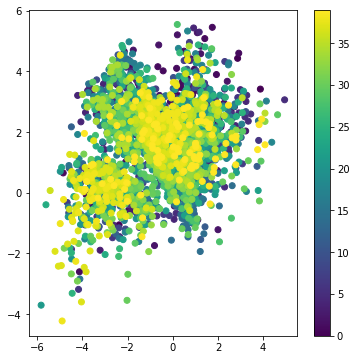

In [38]:
# Plot of the digit classes in the latent space
te_latent = encoder.predict([x_te, y_te], batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(te_latent[:, 0], te_latent[:, 1], c=np.argmax(y_te, axis=1))
plt.colorbar()
plt.show()

In [39]:
# build decoder
decoder_input = Input(shape=(z_dim+y_tr.shape[1],))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 42)]              0         
_________________________________________________________________
dense_20 (Dense)             multiple                  11008     
_________________________________________________________________
dense_21 (Dense)             multiple                  131584    
_________________________________________________________________
dense_22 (Dense)             multiple                  6303744   
Total params: 6,446,336
Trainable params: 6,446,336
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


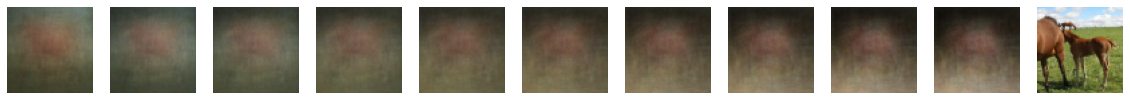

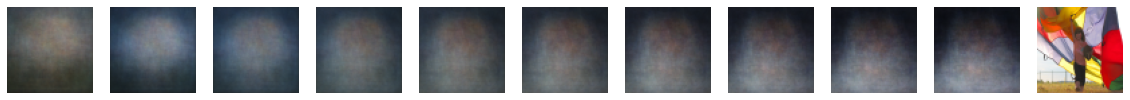

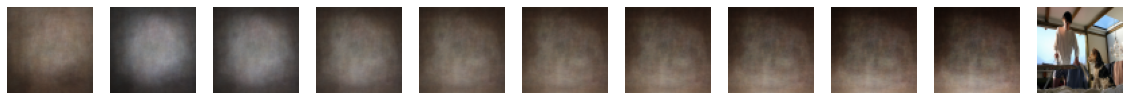

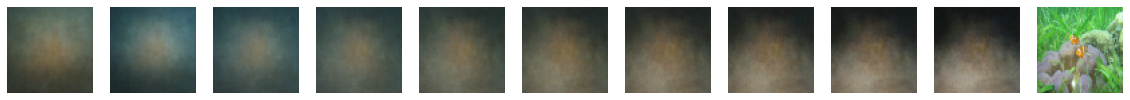

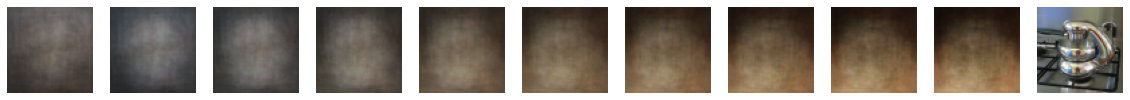

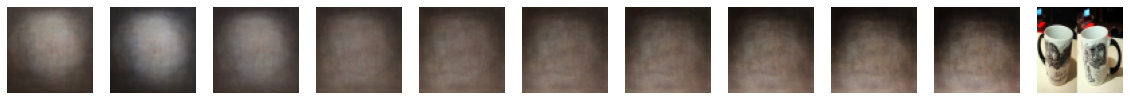

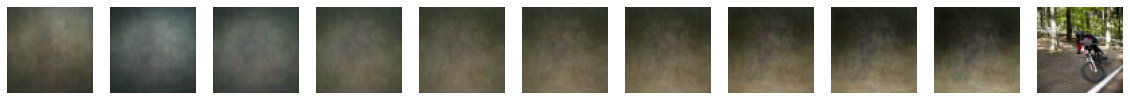

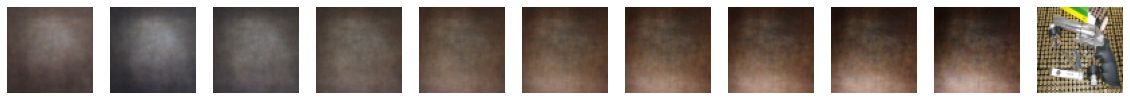

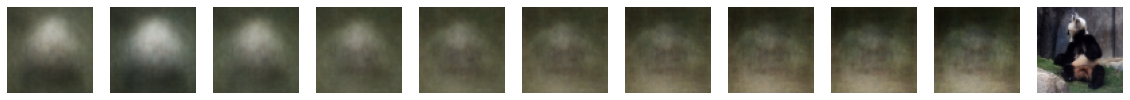

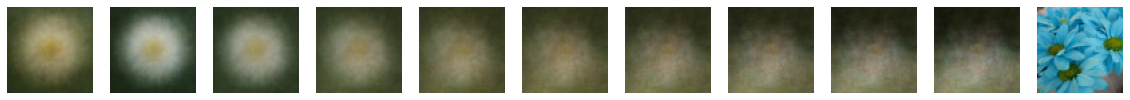

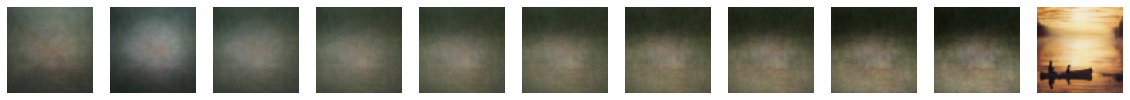

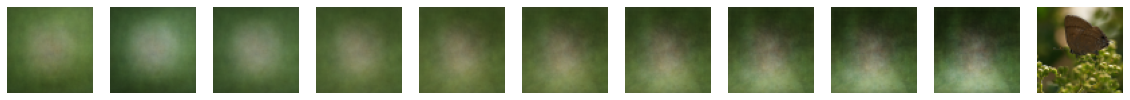

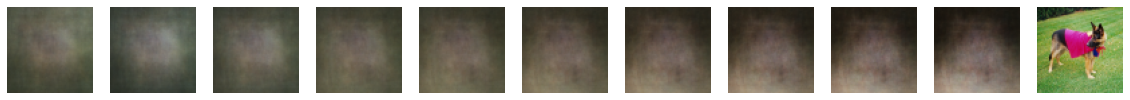

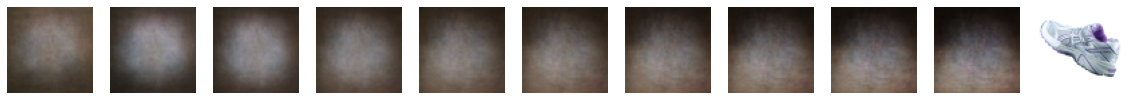

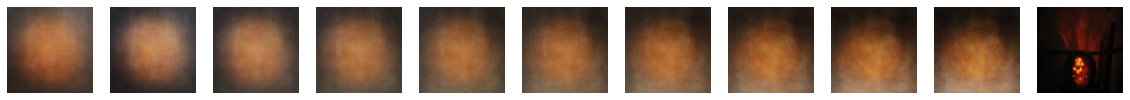

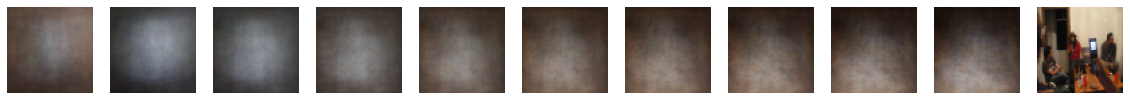

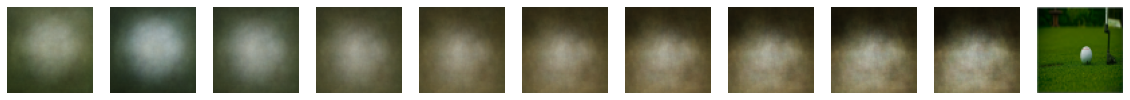

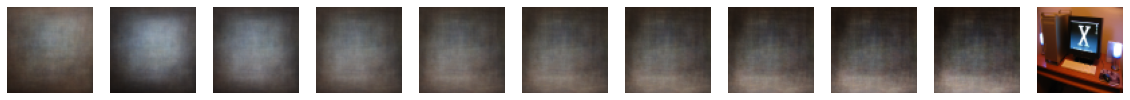

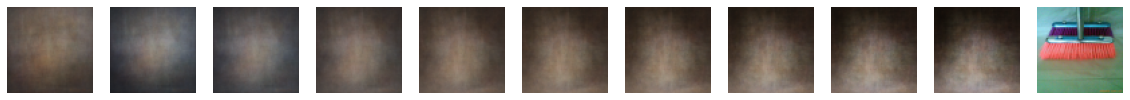

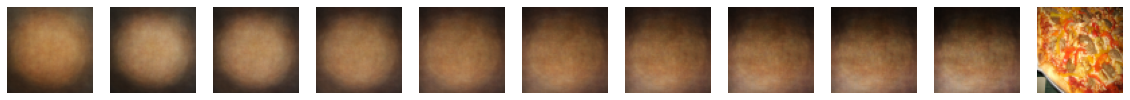

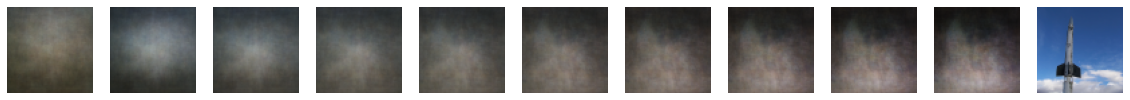

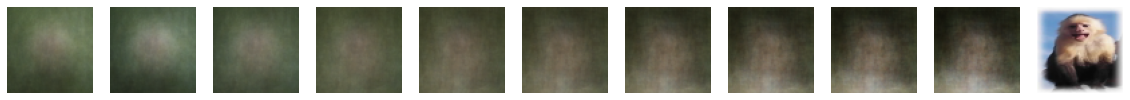

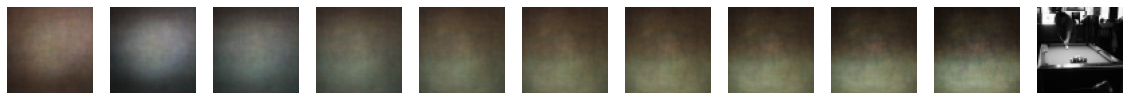

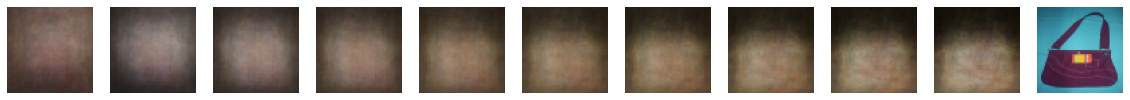

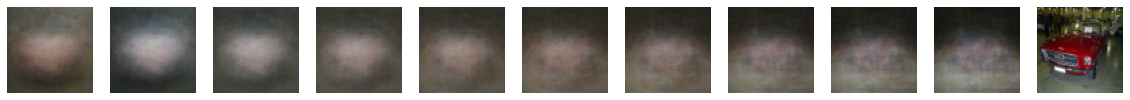

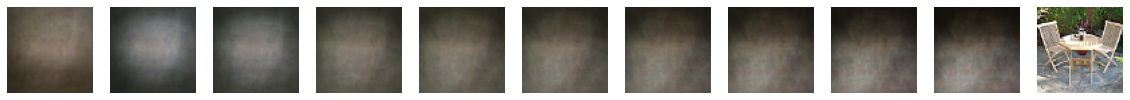

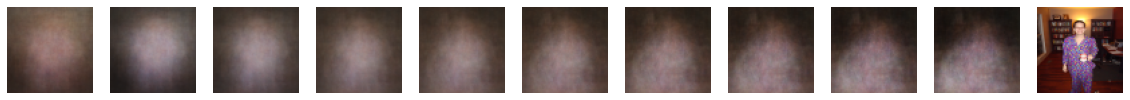

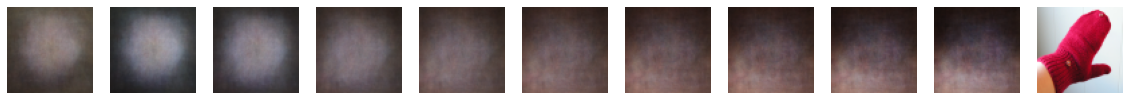

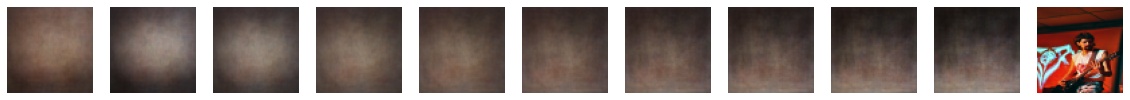

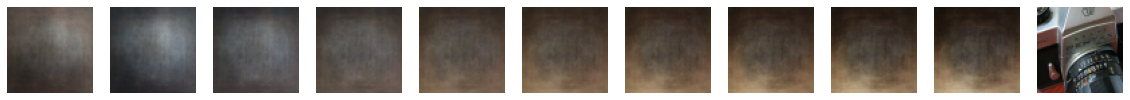

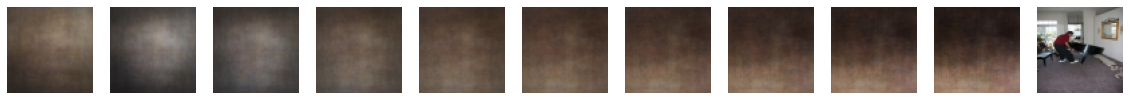

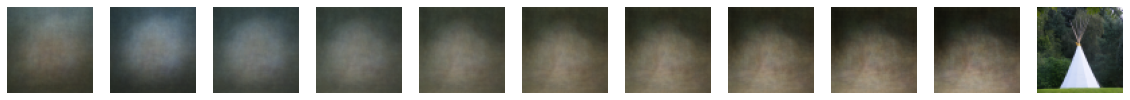

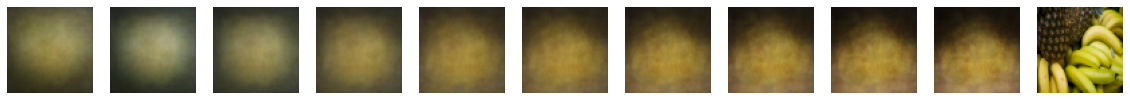

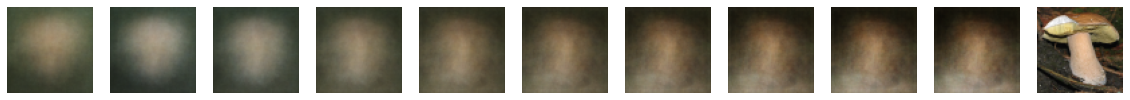

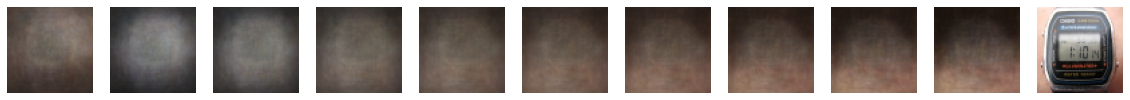

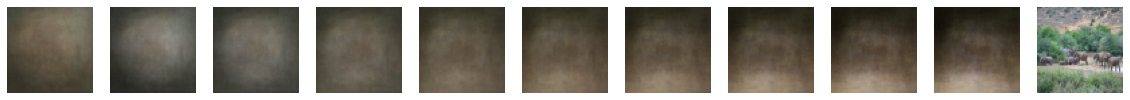

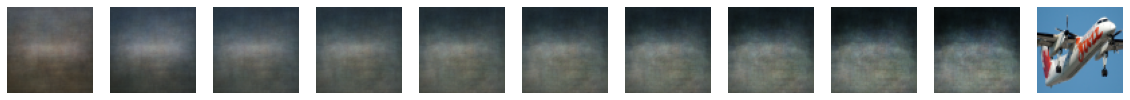

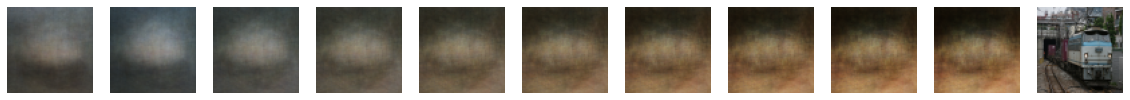

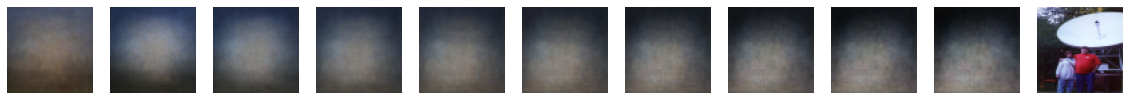

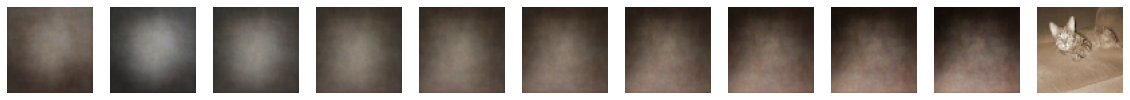

In [42]:

# exploring the latent space: change z sample on the x-axis
img_size = 64
for cond_num in range(40):
    condition_num = to_categorical(cond_num, 40).reshape(1,-1)
    plt.figure(figsize=(20, 2))

    for i in range(11):
        if i == 10:
            img = array_to_image(data[cond_num][0])
            plt.subplot(1, 11, i+1)
            plt.axis('off')
            plt.imshow(img)
        else:
            z_sample = np.array([[0.3*i, 0.9]])
            x_decoded = generator.predict(np.column_stack([z_sample, condition_num]))
            img = array_to_image(x_decoded[0])*255

            plt.subplot(1, 11, i+1)
            plt.axis('off')
            plt.imshow(img)

plt.show()

In [28]:
def sample_label(generator, label):
  number_of_classes = 40
  condition_num = to_categorical(label, number_of_classes).reshape(1,-1)

  z_sample = np.array([[0.3*i, 0.3]])
  x_decoded = generator.predict(np.column_stack([z_sample, condition_num]))
  # sample = generator.predict(label).reshape((28,28))
  digit = array_to_image(x_decoded[0])*255
  return digit

(64, 64, 3)


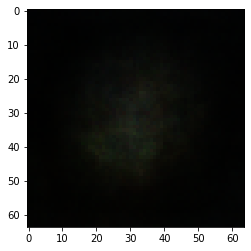

In [29]:
sample = sample_label(generator, 0)
print(sample.shape)
plt.imshow(sample)